# SETUP

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Autosipper

In [ ]:
# config directory must have "__init__.py" file
# from the 'config' directory, import the following classes:
from config import Motor, ASI_Controller, Autosipper
from config import utils as ut

autosipper = Autosipper(Motor('config/motor.yaml'), ASI_Controller('config/asi_controller.yaml'))
autosipper.coord_frames

In [ ]:
from config import gui
gui.stage_control(autosipper.XY, autosipper.Z)

In [ ]:
# add/determine deck info
autosipper.coord_frames.deck.position_table = ut.read_delim_pd('config/position_tables/deck')

# check deck alignment
# CLEAR DECK OF OBSTRUCTIONS!!
autosipper.go_to('deck', ['name'],'align')

In [ ]:
# add plate

In [ ]:
from config import utils as ut
platemap = ut.generate_position_table((8,8),(9,9),93.5)
platemap[]

In [ ]:
ut.lookup(platemap)

### Manifold

In [1]:
from config import Manifold

manifold = Manifold('192.168.1.3', 'config/valvemaps/valvemap.csv', 512)
manifold.valvemap[manifold.valvemap.name>0]

,valve,name
0,0,inlet_out
2,2,inlet_in
8,8,chip_out
9,9,N
10,10,B1
11,11,S1
12,12,S2
13,13,B2
14,14,chip_in


In [ ]:
def valve_states():
    tmp = []
    for i in [2,0,14,8]:
        status = 'x'
        if manifold.read_valve(i):
            status = 'o'
        tmp.append([status, manifold.valvemap.name.iloc[i]])
    return pd.DataFrame(tmp)

In [ ]:
tmp = []
for i in range(16):
    status = 'x'
    if manifold.read_valve(i):
        status = 'o'
    name = manifold.valvemap.name.iloc[i]
    tmp.append([status, name])
pd.DataFrame(tmp).replace(np.nan, '')

In [ ]:
name = 'inlet_in'
v = manifold.valvemap['valve'][manifold.valvemap.name==name]

In [ ]:
v=14

In [ ]:
manifold.depressurize(v)

In [ ]:
manifold.pressurize(v)

In [ ]:
manifold.exit()

### Micromanager

In [3]:
# !!!! Also must have MM folder on system PATH
# mm_version = 'C:\Micro-Manager-1.4'
# cfg = 'C:\Micro-Manager-1.4\SetupNumber2_05102016.cfg'
mm_version = 'C:\Program Files\Micro-Manager-2.0beta'
cfg = 'C:\Program Files\Micro-Manager-2.0beta\Setup2_20170413.cfg'

import sys
sys.path.insert(0, mm_version) # make it so python can find MMCorePy
import MMCorePy

from PIL import Image

core = MMCorePy.CMMCore()
core.loadSystemConfiguration(cfg)
core.setProperty("Spectra", "White_Enable", "1")
core.waitForDevice("Spectra")

core.setProperty("Cam Andor_Zyla4.2", "Sensitivity/DynamicRange", "16-bit (low noise & high well capacity)") # NEED TO SET CAMERA TO 16 BIT (ceiling 12 BIT = 4096)

In [14]:
core.setProperty("Spectra", "White_Enable", "0")

Preset: 1_PBP   
ConfigGroup,Channel,1_PBP,TIFilterBlock1,Label,1-PBP

Preset: 2_BF    
ConfigGroup,Channel,2_BF,TIFilterBlock1,Label,2-BF

Preset: 3_DAPI   
ConfigGroup,Channel,3_DAPI,TIFilterBlock1,Label,3-DAPI

Preset: 4_eGFP   
ConfigGroup,Channel,4_eGFP,TIFilterBlock1,Label,4-GFP

Preset: 5_Cy5   
ConfigGroup,Channel,5_Cy5,TIFilterBlock1,Label,5-Cy5

Preset: 6_AttoPhos   
ConfigGroup,Channel,6_AttoPhos,TIFilterBlock1,Label,6-AttoPhos

# TEST

4.5 psi, 25 psi valves

In [ ]:
log = []

In [ ]:
autosipper.Z.move(93.5)
manifold.depressurize(2)
manifold.depressurize(0)
log.append([time.ctime(time.time()), 'open inlet_in, inlet_out'])
valve_states()

In [ ]:
text = 'fluorescence observed'
log.append([time.ctime(time.time()), text])

In [ ]:
text = 'CLOSE inlet_out'
manifold.pressurize(0)
log.append([time.ctime(time.time()), text])

text = 'OPEN chip_in, chip_out'
manifold.depressurize(14)
manifold.depressurize(8)
log.append([time.ctime(time.time()), text])

valve_states()

In [ ]:
text = 'fill'
log.append([time.ctime(time.time()), text])
manifold.pressurize(8)
#closed all

In [ ]:
autosipper.Z.move(93.5)
manifold.depressurize(2)
manifold.depressurize(0)
log.append([time.ctime(time.time()), 'open inlet_in, inlet_out'])
valve_states()

In [ ]:
text = 'fluorescence removed'
log.append([time.ctime(time.time()), text])

In [ ]:
text = 'CLOSE inlet_out'
manifold.pressurize(0)
log.append([time.ctime(time.time()), text])

text = 'OPEN chip_in, chip_out'
manifold.depressurize(14)
manifold.depressurize(8)
log.append([time.ctime(time.time()), text])

valve_states()

In [ ]:
text = 'flush'
log.append([time.ctime(time.time()), text])
manifold.pressurize(8)

In [ ]:
for i in [2,0,14,8]:
    manifold.pressurize(i)

# ACQUISITION

In [ ]:
log

In [4]:
core.setConfig('Channel','2_BF')

In [ ]:
core.setProperty(core.getCameraDevice(), "Exposure", 20)

In [ ]:
core.snapImage()
img = core.getImage()
plt.imshow(img,cmap='gray')
image = Image.fromarray(img)
# image.save('TESTIMAGE.tif')

In [10]:
import config.utils as ut
position_list = ut.load_mm_positionlist("C:/Users/fordycelab/Desktop/D1_cjm.pos")
position_list

,r,c,name,x,y
0,0,0,1-Pos_000_000,-16212.71272,-19875.62168
1,0,1,1-Pos_001_000,-13894.29480,-19875.62168
2,0,2,1-Pos_002_000,-11575.87688,-19875.62168
3,0,3,1-Pos_003_000,-9257.45896,-19875.62168
4,0,4,1-Pos_004_000,-6939.04104,-19875.62168
5,0,5,1-Pos_005_000,-4620.62312,-19875.62168
6,0,6,1-Pos_006_000,-2302.20520,-19875.62168
7,0,7,1-Pos_007_000,16.21272,-19875.62168
8,1,7,1-Pos_007_001,16.21272,-17557.20376
9,1,6,1-Pos_006_001,-2302.20520,-17557.20376


In [8]:
def acquire():
    for i in xrange(len(position_list)):
        si = str(i)
        x,y = position_list[['x','y']].iloc[i]
        core.setXYPosition(x,y)
        core.waitForDevice(core.getXYStageDevice())
        logadd(core, log, 'moved '+si)
        
        core.snapImage()
#         core.waitForDevice(core.getCameraDevice())
        logadd(core, log, 'snapped '+si)
        
        img = core.getImage()
        logadd(core, log, 'got image '+si)
        
        image = Image.fromarray(img)
        image.save('images/images_{}.tif'.format(i))
        logadd(core, log, 'saved image '+si)
    
    x,y = position_list[['x','y']].iloc[0]
    core.setXYPosition(x,y)
    core.waitForDevice(core.getXYStageDevice())
    logadd(core, log, 'moved '+ str(0))
        
def logadd(core,log,st):
    log.append([time.ctime(time.time()), st])
    core.logMessage(st)
    print log[-1]

In [ ]:
# Trial 1: returning stage to home at end of acquire
log = []
for i in xrange(15):
    sleep = (10*i)*60
    logadd(log, 'STRT SLEEP '+ str(sleep/60) + ' min')
    time.sleep(sleep)
    
    logadd(log, 'ACQ STARTED '+str(i))
    acquire()

['Wed May 24 11:41:13 2017', 'STRT SLEEP 0 min']
['Wed May 24 11:41:13 2017', 'ACQ STARTED 0']
['Wed May 24 11:41:16 2017', 'moved 0']
['Wed May 24 11:41:16 2017', 'snapped 0']
['Wed May 24 11:41:16 2017', 'got image 0']
['Wed May 24 11:41:16 2017', 'saved image 0']
['Wed May 24 11:41:17 2017', 'moved 1']
['Wed May 24 11:41:17 2017', 'snapped 1']
['Wed May 24 11:41:17 2017', 'got image 1']
['Wed May 24 11:41:17 2017', 'saved image 1']
['Wed May 24 11:41:18 2017', 'moved 2']
['Wed May 24 11:41:18 2017', 'snapped 2']
['Wed May 24 11:41:18 2017', 'got image 2']
['Wed May 24 11:41:18 2017', 'saved image 2']
['Wed May 24 11:41:19 2017', 'moved 3']
['Wed May 24 11:41:19 2017', 'snapped 3']
['Wed May 24 11:41:19 2017', 'got image 3']
['Wed May 24 11:41:19 2017', 'saved image 3']
['Wed May 24 11:41:19 2017', 'moved 4']
['Wed May 24 11:41:19 2017', 'snapped 4']
['Wed May 24 11:41:19 2017', 'got image 4']
['Wed May 24 11:41:19 2017', 'saved image 4']
['Wed May 24 11:41:20 2017', 'moved 5']
['Wed

In [21]:
core.stopSecondaryLogFile(l2)

In [ ]:
# Trial 2: returning stage to home at end of acquire
# added mm logs

# core.setPrimaryLogFile('20170524_log_prim2.txt')
# core.enableDebugLog(True)
# core.enableStderrLog(True)
l2 = core.startSecondaryLogFile('20170524_log_sec3.txt', True, False, True)

log = []
for i in xrange(15):
    sleep = (10*i)*60
    logadd(core, log, 'STRT SLEEP '+ str(sleep/60) + ' min')
    time.sleep(sleep)
    
    logadd(core, log, 'ACQ STARTED '+str(i))
    acquire()

core.stopSecondaryLogFile(l2)

['Wed May 24 15:23:14 2017', 'STRT SLEEP 0 min']
['Wed May 24 15:23:14 2017', 'ACQ STARTED 0']


In [ ]:
# Trial 3: returning stage to home at end of acquire
# added mm logs

# core.setPrimaryLogFile('20170524_log_prim2.txt')
# core.enableDebugLog(True)
# core.enableStderrLog(True)
l2 = core.startSecondaryLogFile('20170524_log_sec3.txt', True, False, True)

log = []
for i in xrange(15):
    sleep = (10*i)*60
    logadd(core, log, 'STRT SLEEP '+ str(sleep/60) + ' min')
    time.sleep(sleep)
    
    logadd(core, log, 'ACQ STARTED '+str(i))
    acquire()

core.stopSecondaryLogFile(l2)

['Wed May 24 15:25:23 2017', 'STRT SLEEP 0 min']
['Wed May 24 15:25:23 2017', 'ACQ STARTED 0']
['Wed May 24 15:25:24 2017', 'moved 0']
['Wed May 24 15:25:24 2017', 'snapped 0']
['Wed May 24 15:25:24 2017', 'got image 0']
['Wed May 24 15:25:24 2017', 'saved image 0']
['Wed May 24 15:25:25 2017', 'moved 1']
['Wed May 24 15:25:25 2017', 'snapped 1']
['Wed May 24 15:25:25 2017', 'got image 1']
['Wed May 24 15:25:25 2017', 'saved image 1']
['Wed May 24 15:25:26 2017', 'moved 2']
['Wed May 24 15:25:26 2017', 'snapped 2']
['Wed May 24 15:25:26 2017', 'got image 2']
['Wed May 24 15:25:26 2017', 'saved image 2']
['Wed May 24 15:25:26 2017', 'moved 3']
['Wed May 24 15:25:26 2017', 'snapped 3']
['Wed May 24 15:25:26 2017', 'got image 3']
['Wed May 24 15:25:26 2017', 'saved image 3']
['Wed May 24 15:25:27 2017', 'moved 4']
['Wed May 24 15:25:27 2017', 'snapped 4']
['Wed May 24 15:25:27 2017', 'got image 4']
['Wed May 24 15:25:27 2017', 'saved image 4']
['Wed May 24 15:25:28 2017', 'moved 5']
['Wed

In [11]:
# Trial 4: returning stage to home at end of acquire
# added mm logs
# after USB fix

# core.setPrimaryLogFile('20170524_log_prim2.txt')
# core.enableDebugLog(True)
# core.enableStderrLog(True)
l2 = core.startSecondaryLogFile('20170526_log_sec4.txt', True, False, True)

log = []
for i in xrange(15):
    sleep = (5*i)*60
    logadd(core, log, 'STRT SLEEP '+ str(sleep/60) + ' min')
    time.sleep(sleep)
    
    logadd(core, log, 'ACQ STARTED '+str(i))
    acquire()

core.stopSecondaryLogFile(l2)

['Fri May 26 10:00:28 2017', 'STRT SLEEP 0 min']
['Fri May 26 10:00:28 2017', 'ACQ STARTED 0']
['Fri May 26 10:00:31 2017', 'moved 0']
['Fri May 26 10:00:31 2017', 'snapped 0']
['Fri May 26 10:00:31 2017', 'got image 0']
['Fri May 26 10:00:31 2017', 'saved image 0']
['Fri May 26 10:00:32 2017', 'moved 1']
['Fri May 26 10:00:32 2017', 'snapped 1']
['Fri May 26 10:00:32 2017', 'got image 1']
['Fri May 26 10:00:32 2017', 'saved image 1']
['Fri May 26 10:00:33 2017', 'moved 2']
['Fri May 26 10:00:33 2017', 'snapped 2']
['Fri May 26 10:00:33 2017', 'got image 2']
['Fri May 26 10:00:33 2017', 'saved image 2']
['Fri May 26 10:00:34 2017', 'moved 3']
['Fri May 26 10:00:34 2017', 'snapped 3']
['Fri May 26 10:00:34 2017', 'got image 3']
['Fri May 26 10:00:34 2017', 'saved image 3']
['Fri May 26 10:00:35 2017', 'moved 4']
['Fri May 26 10:00:35 2017', 'snapped 4']
['Fri May 26 10:00:35 2017', 'got image 4']
['Fri May 26 10:00:35 2017', 'saved image 4']
['Fri May 26 10:00:36 2017', 'moved 5']
['Fri

In [12]:
# Trial 5: returning stage to home at end of acquire
# second one after USB fix

# core.setPrimaryLogFile('20170524_log_prim2.txt')
# core.enableDebugLog(True)
# core.enableStderrLog(True)
l2 = core.startSecondaryLogFile('20170526_log_sec5.txt', True, False, True)

log = []
for i in xrange(15):
    sleep = (10*i)*60
    logadd(core, log, 'STRT SLEEP '+ str(sleep/60) + ' min')
    time.sleep(sleep)
    
    logadd(core, log, 'ACQ STARTED '+str(i))
    acquire()

core.stopSecondaryLogFile(l2)

['Sat May 27 15:44:52 2017', 'STRT SLEEP 0 min']
['Sat May 27 15:44:52 2017', 'ACQ STARTED 0']
['Sat May 27 15:44:52 2017', 'moved 0']
['Sat May 27 15:44:52 2017', 'snapped 0']
['Sat May 27 15:44:53 2017', 'got image 0']
['Sat May 27 15:44:53 2017', 'saved image 0']
['Sat May 27 15:44:53 2017', 'moved 1']
['Sat May 27 15:44:53 2017', 'snapped 1']
['Sat May 27 15:44:53 2017', 'got image 1']
['Sat May 27 15:44:53 2017', 'saved image 1']
['Sat May 27 15:44:54 2017', 'moved 2']
['Sat May 27 15:44:54 2017', 'snapped 2']
['Sat May 27 15:44:54 2017', 'got image 2']
['Sat May 27 15:44:54 2017', 'saved image 2']
['Sat May 27 15:44:55 2017', 'moved 3']
['Sat May 27 15:44:55 2017', 'snapped 3']
['Sat May 27 15:44:55 2017', 'got image 3']
['Sat May 27 15:44:55 2017', 'saved image 3']
['Sat May 27 15:44:56 2017', 'moved 4']
['Sat May 27 15:44:56 2017', 'snapped 4']
['Sat May 27 15:44:56 2017', 'got image 4']
['Sat May 27 15:44:56 2017', 'saved image 4']
['Sat May 27 15:44:57 2017', 'moved 5']
['Sat

In [ ]:
# Auto
core.setAutoShutter(True) # default
core.snapImage()

# Manual
core.setAutoShutter(False) # disable auto shutter
core.setProperty("Shutter", "State", "1")
core.waitForDevice("Shutter")
core.snapImage()
core.setProperty("Shutter", "State", "0")

### MM Get info

In [ ]:
core.getFocusDevice()
core.getCameraDevice()
core.XYStageDevice()
core.getDevicePropertyNames(core.getCameraDevice())

### Video

In [ ]:
import cv2
from IPython import display
import numpy as np
from ipywidgets import widgets
import time

In [ ]:
# core.initializeCircularBuffer()
# core.setCircularBufferMemoryFootprint(4096) # MiB 

In [ ]:
cv2.WND

In [ ]:
# video with button (CV2)
live = widgets.Button(description='Live')
close = widgets.Button(description='Close')
display.display(widgets.HBox([live, close]))
 
def on_live_clicked(b):
    display.clear_output(wait=True)
    print 'LIVE'
    core.startContinuousSequenceAcquisition(1000) # time overridden by exposure
    time.sleep(.2)
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Video', cv2.WND_PROP_ASPECT_RATIO, cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('Video', 500,500)
    img = np.zeros((500,500))
    print 'To stop, click window + press ESC'
    while(1):
        time.sleep(.015)
        if core.getRemainingImageCount() > 0:
            img = core.getLastImage()
        cv2.imshow('Video',img)
        k = cv2.waitKey(30)
        if k==27: # ESC key; may need 255 mask?
            break
    print 'STOPPED'
    core.stopSequenceAcquisition()

def on_close_clicked(b):
    if core.isSequenceRunning():
        core.stopSequenceAcquisition()
    cv2.destroyWindow('Video')
        
live.on_click(on_live_clicked)
close.on_click(on_close_clicked)

In [ ]:
# video with button (CV2)
# serial snap image
live = widgets.Button(description='Live')
close = widgets.Button(description='Close')
display.display(widgets.HBox([live, close]))
 
def on_live_clicked(b):
    display.clear_output(wait=True)
    print 'LIVE'
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Video', cv2.WND_PROP_ASPECT_RATIO, cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('Video', 500,500)
    img = np.zeros((500,500))
    print 'To stop, click window + press ESC'
    while(1):
        core.snapImage()
        time.sleep(.05)
        img = core.getImage()
        cv2.imshow('Video',img)
        k = cv2.waitKey(30)
        if k==27: # ESC key; may need 255 mask?
            break
    print 'STOPPED'

def on_close_clicked(b):
    if core.isSequenceRunning():
        core.stopSequenceAcquisition()
    cv2.destroyWindow('Video')
        
live.on_click(on_live_clicked)
close.on_click(on_close_clicked)

In [ ]:
cv2.destroyAllWindows()

# SNAP CV2

In [ ]:
# snap (CV2)
snap = widgets.Button(description='Snap')
close2 = widgets.Button(description='Close')
display.display(widgets.HBox([snap, close2]))
                
def on_snap_clicked(b):
    cv2.destroyWindow('Snap')
    cv2.namedWindow('Snap',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Snap', 500,500)
    cv2.setWindowProperty('Snap', cv2.WND_PROP_ASPECT_RATIO, cv2.WINDOW_KEEPRATIO)
    core.snapImage()
    time.sleep(.1)
    img = core.getImage()
    cv2.imshow('Snap',img)
    k = cv2.waitKey(30)
    
def on_close2_clicked(b):
    cv2.destroyWindow('Snap')
        
snap.on_click(on_snap_clicked)
close2.on_click(on_close2_clicked)

# EXIT

In [ ]:
autosipper.exit()
manifold.exit()
core.unloadAllDevices()
core.reset()
print 'closed'

In [5]:
import config.gui as gui

In [ ]:
core.

In [6]:
gui.video(core)

LIVE
To stop, click window + press ESC
STOPPED


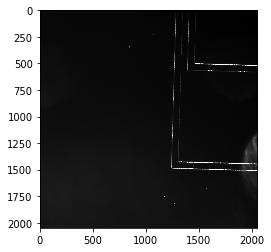

In [11]:
gui.snap(core, 'mpl')

In [3]:
gui.manifold_control(manifold)